# Self-Driving Car
## Project 5: Vehicle Detection
### Kimon Roufas

---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!




### Imports

In [1]:
#importing some useful packages
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import glob
import pprint
from random import randint
from collections import deque
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

print('Numpy version: {}'.format(np.__version__))
print('OpenCV version: {}'.format(cv2.__version__))
# print('MatPlotLib version: {}'.format(matplotlib.__version__)) # v2.0.2

Numpy version: 1.13.3
OpenCV version: 3.1.0


### Helper Functions

In [9]:
images = [
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg'
]
test_images = []
for fname in images:
    test_images.append(mpimg.imread(fname))
test1, test2, test3, test4, test5, test6 = test_images

def display_two_images(img1, title1, img2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title(title1, fontsize=40)
    ax1.imshow(img1)
    ax2.set_title(title2, fontsize=40)
    ax2.imshow(img2)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
def load_image_names():
    # Divide up into cars and notcars
    cars = glob.glob('./training_images/vehicles/*/*.png')
    notcars = glob.glob('./training_images/non-vehicles/*/*.png')
    print('Number of cars: {0}, notcars: {1}'.format(len(cars), len(notcars)))
    return (cars, notcars)

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

Number of cars: 8792, notcars: 8968


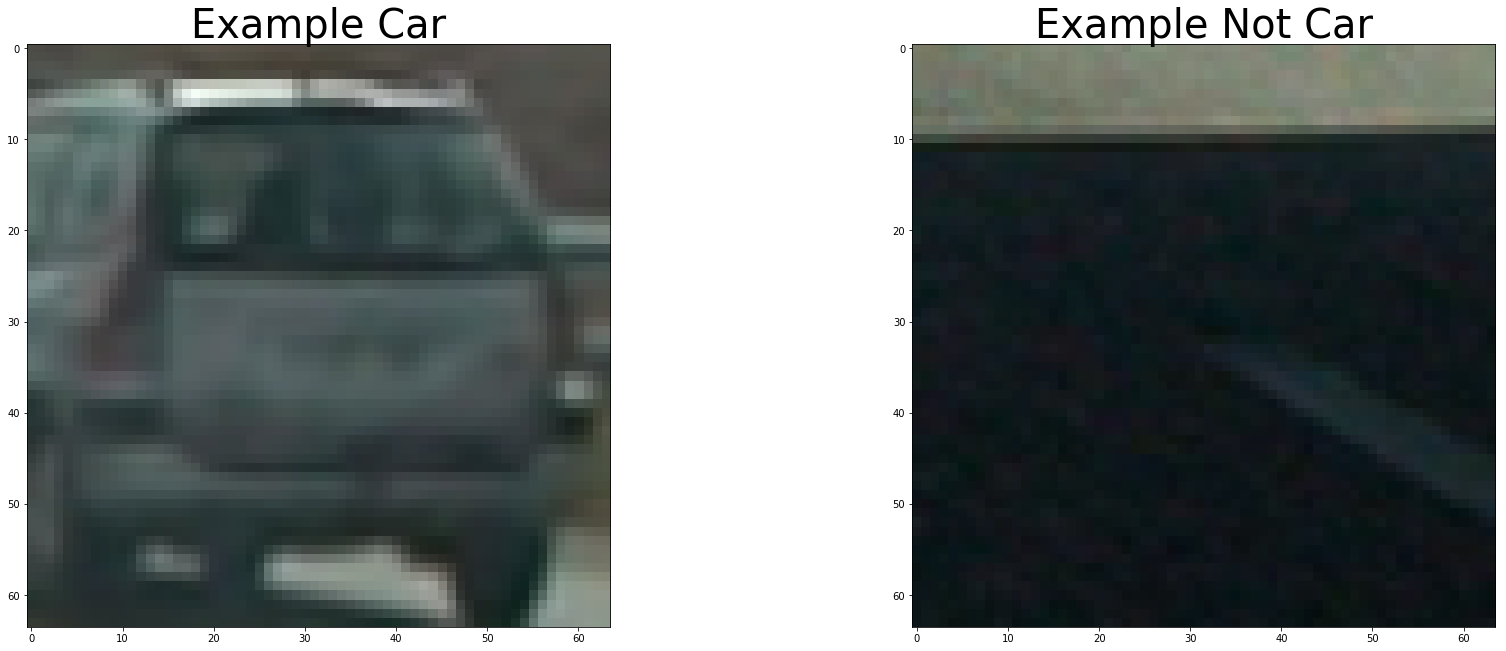

In [10]:
cars, notcars = load_image_names()

car0 = mpimg.imread(cars[0])
notcar0 = mpimg.imread(notcars[0])
display_two_images(car0, 'Example Car', notcar0, 'Example Not Car')

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`). I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:




TypeError: Image data cannot be converted to float

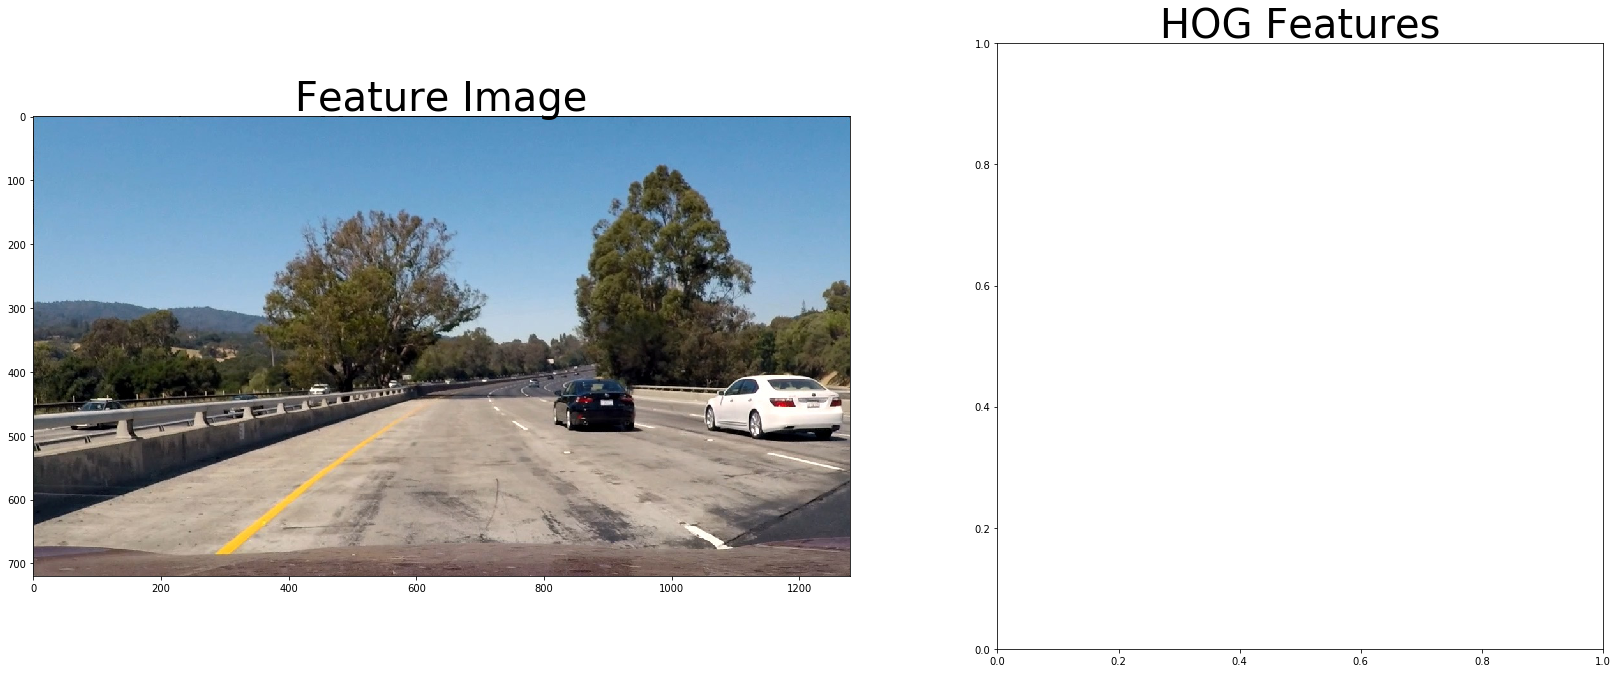

In [18]:
class Config():
    def __init__(self):
        self.cspace = 'RGB'
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 0
        self.vis = True


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to apply color conversion if other than 'RGB'
def color_conversion(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(feature_image, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # # Create a list to append feature vectors to
    # features = []
    # # Iterate through the list of images
    # for file in imgs:
    #     # Read in each one by one
    #     # apply color conversion if other than 'RGB'

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        hog_images = []
        for channel in range(feature_image.shape[2]):
            if vis==True:
                temp_features, temp_image = get_hog_features(feature_image[:,:,channel],
                                                            orient, pix_per_cell, cell_per_block,
                                                            vis=True, feature_vec=True)
                hog_features.append(temp_features)
                hog_images.append(temp_image)
            else:            
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        if vis==True:
            hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # # Append the new feature vector to the features list
    # features.append(hog_features)
    # Return list of feature vectors
    if vis==True:
        return (hog_features, hog_images)
    else:
        return hog_features


def pipeline(image, config=Config()):
    feature_image = color_conversion(image, config.cspace)
    hog_features = extract_features(feature_image, orient=config.orient, pix_per_cell=config.pix_per_cell,
                                    cell_per_block=config.cell_per_block, hog_channel=config.hog_channel, 
                                    vis=config.vis)
    return (feature_image, hog_features)


feature_image, hog_features = pipeline(test1)
display_two_images(feature_image, 'Feature Image', hog_features, 'HOG Features')

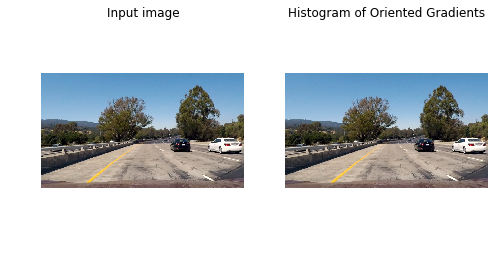

In [4]:
from skimage import exposure

import feature_extraction as fe

image = test1

c = fe.Config()
c.vis = True
hog_image, hog_features = fe.pipeline(test1, config=c)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

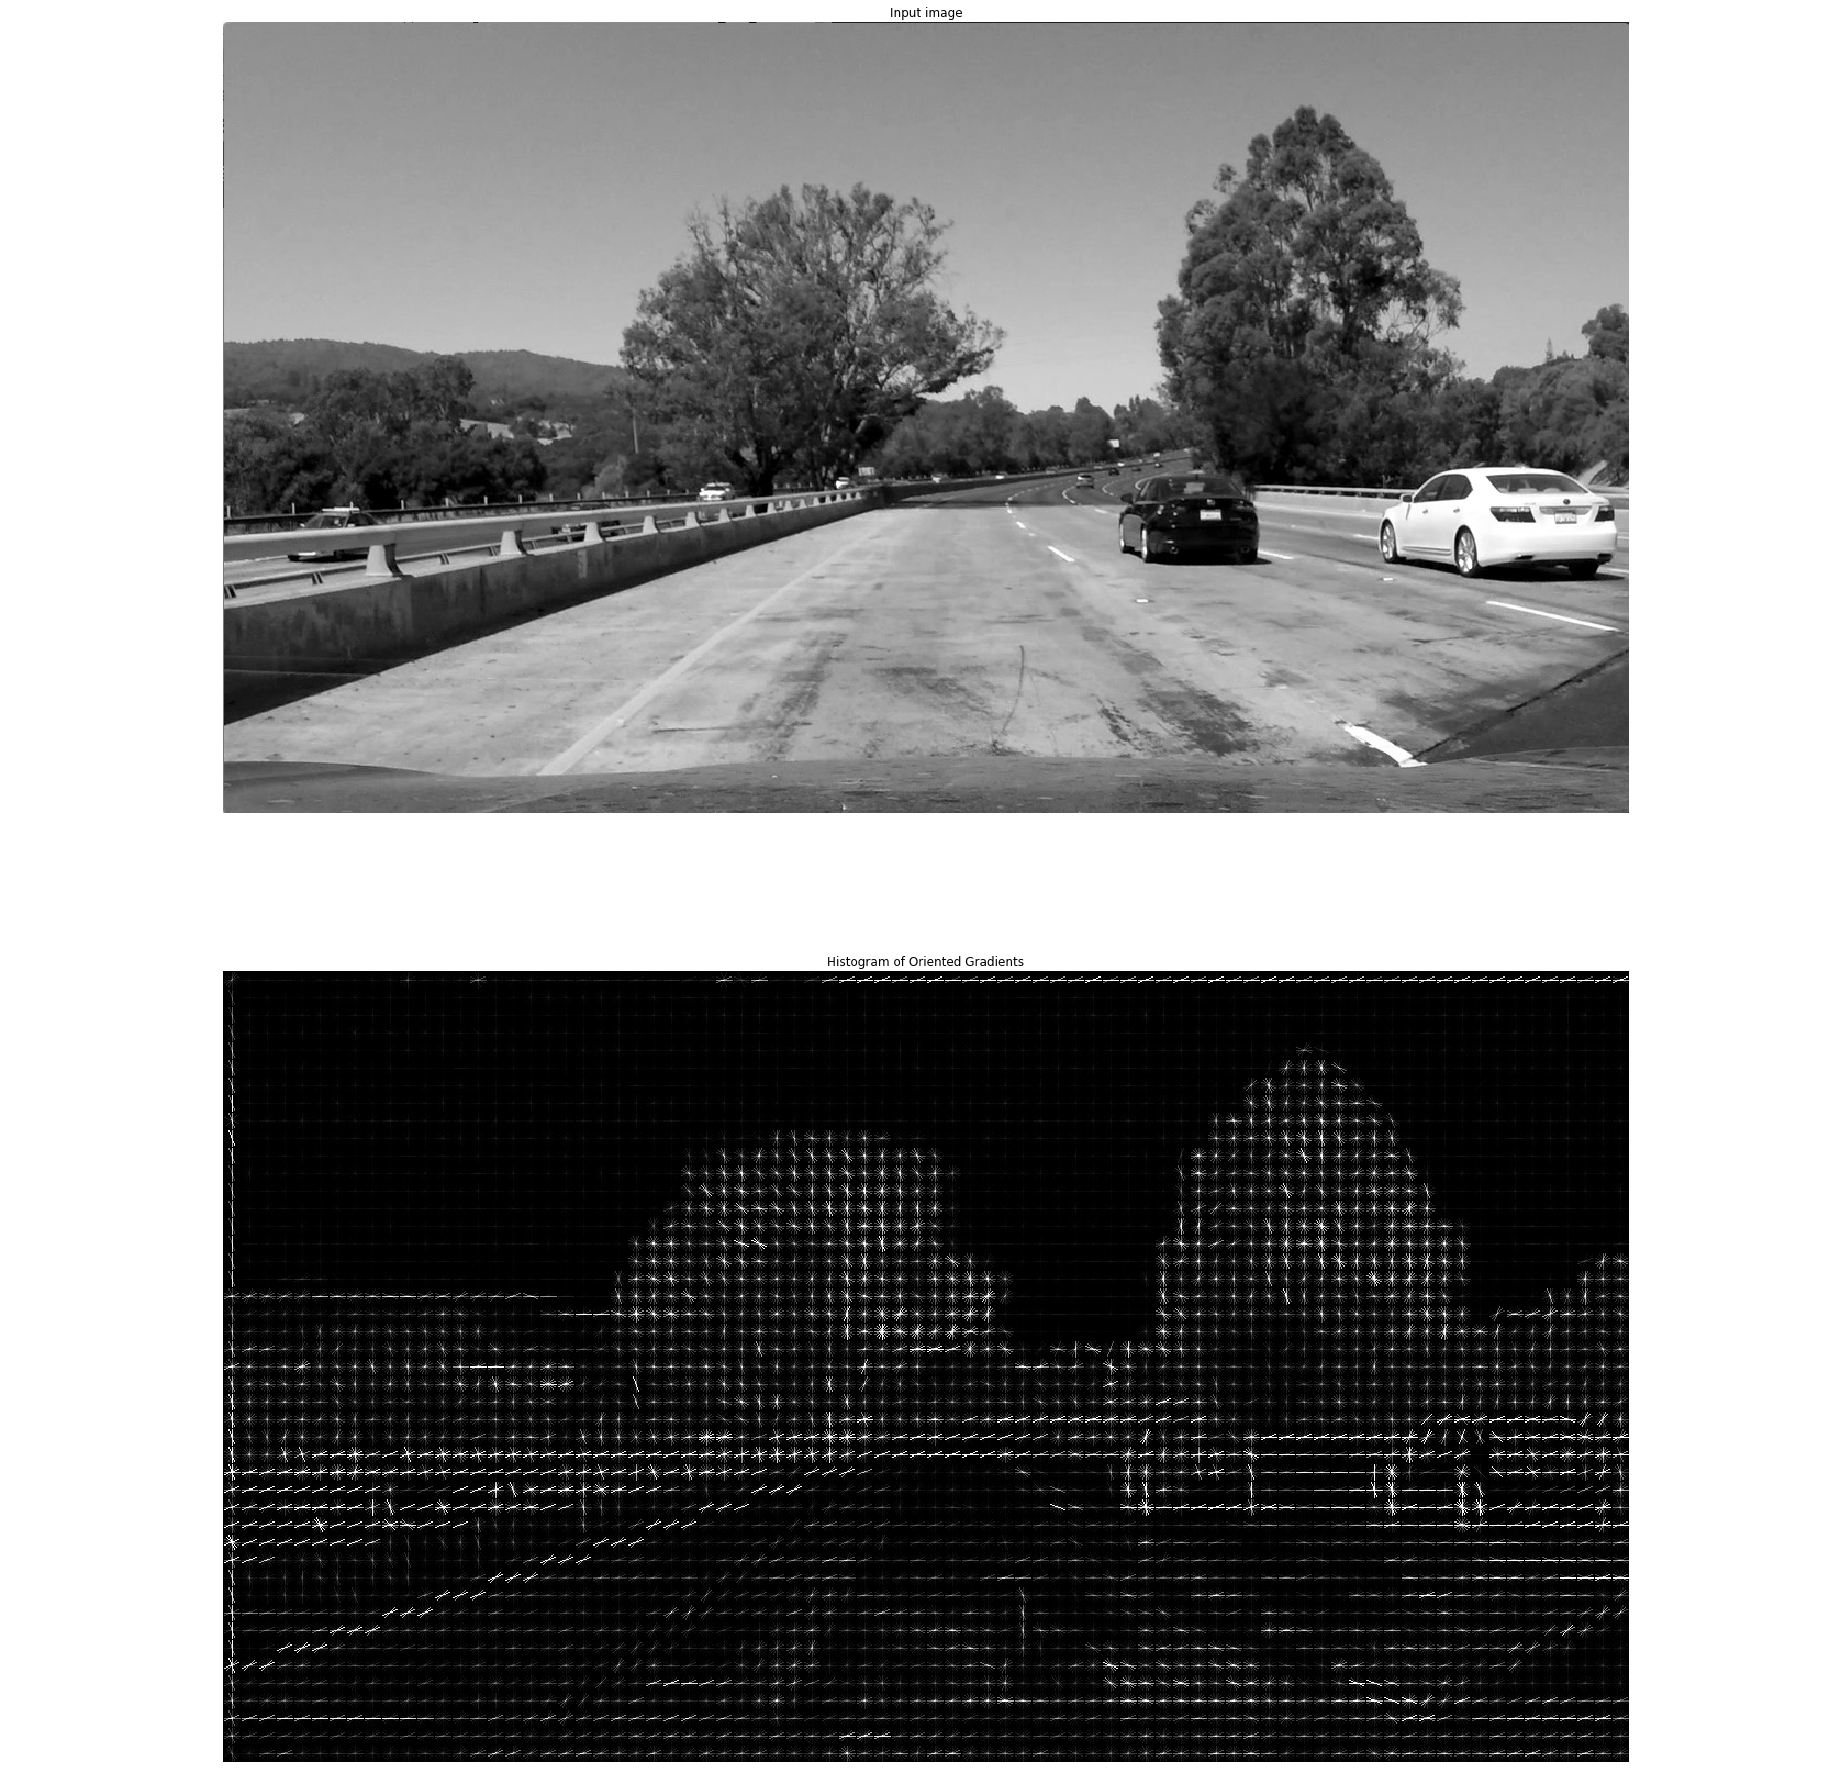

In [5]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure


image = color.rgb2gray(test1)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(32, 32), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [6]:
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)



[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]
---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

